# Replication of Newman *et al.* (2015) *in-vitro* optoclamp

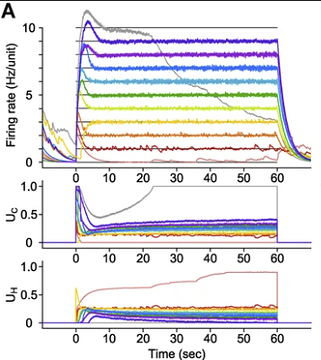

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
import cleo

b2.prefs.codegen.target = 'cython'
rng = np.random.default_rng()
plt.rc('svg', fonttype='none')

WARNING    /home/kyle/miniforge3/envs/cleo/lib/python3.12/site-packages/attr/_make.py:918: RuntimeWarning: Running interpreter doesn't sufficiently support code object introspection.  Some features like bare super() or accessing __class__ will not work with slotted classes.
  set_closure_cell(cell, cls)
 [py.warnings]


## Balanced E/I network
from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network)

In [2]:
from random import sample

b2.defaultclock.dt = 0.2 * b2.ms

N_Excit=800
N_Inhib=None  # None = N_Excit / 4
N_extern=1000
connection_probability=0.1
w0=0.78 * b2.mV
g=7.5
synaptic_delay=1.5 * b2.ms
poisson_input_rate=8.2 * b2.Hz
w_external=None
w_external=0.1 * b2.mV
v_rest=-70 * b2.mV
v_reset=-60 * b2.mV
firing_threshold=-50 * b2.mV
membrane_time_scale=20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period=2 * b2.ms
monitored_subset_size=100
random_vm_init=True
"""
Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

Args:
    N_Excit (int): Size of the excitatory popluation
    N_Inhib (int): optional. Size of the inhibitory population.
        If not set (=None), N_Inhib is set to N_excit/4.
    N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
        this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
        from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
        N_Excit*connection_probability.
    connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
        CE = connection_probability*N_Excit
        CI = connection_probability*N_Inhib
        Cexternal = N_extern
    w0 (float): Synaptic strength J
    g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
    synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
    poisson_input_rate (Quantity): Poisson rate of the external population
    w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
        neurons in the network. Default is None, in that case w_external is set to w0, which is the
        standard value in the book and in the paper Brunel2000.
        The purpose of this parameter is to see the effect of external input in the
        absence of network feedback(setting w0 to 0mV and w_external>0).
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset potential
    firing_threshold (Quantity): Spike threshold
    membrane_time_scale (Quantity): tau_m
    abs_refractory_period (Quantity): absolute refractory period, tau_ref
    monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
    random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
        random value drawn from Uniform(v_rest, firing_threshold)
    sim_time (Quantity): Simulation time

Returns:
    (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
    PopulationRateMonitor: Rate Monitor
    SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
    StateMonitor: membrane voltage for a selected subset of neurons
    list: index of monitored neurons. length = monitored_subset_size
"""
if N_Inhib is None:
    N_Inhib = int(N_Excit / 4)
if N_extern is None:
    N_extern = int(N_Excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
dv/dt = (-(v-v_rest) + Rm*(I_ChR2R + I_eNpHR3)) / membrane_time_scale : volt (unless refractory)
I_ChR2R : amp
I_eNpHR3 : amp
"""

neurons = b2.NeuronGroup(
    N_Excit + N_Inhib,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_Excit + N_Inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_Excit]
inhibitory_population = neurons[N_Excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    on_pre="v += J_excit",
    delay=synaptic_delay,
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    on_pre="v += J_inhib",
    delay=synaptic_delay,
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

# collect data of a subset of neurons:
monitored_subset_size = min(monitored_subset_size, (N_Excit + N_Inhib))
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)
# rate_monitor = b2.PopulationRateMonitor(neurons)
# record= some_list is not supported? :-(
# spike_monitor = b2.SpikeMonitor(neurons, record=idx_monitored_neurons)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    # rate_monitor,
    # spike_monitor,
    # voltage_monitor,
)

# net.run(3 * b2.second)
# plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=0.5)
# plt.xlim(0, 10000)

In [3]:
sim = cleo.CLSimulator(net)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/utilities.py:91: RuntimeWarning: invalid value encountered in divide
  c = (xyz_end - xyz_start) / cyl_length  # unit vector in direction of cylinder
 [py.warnings]


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

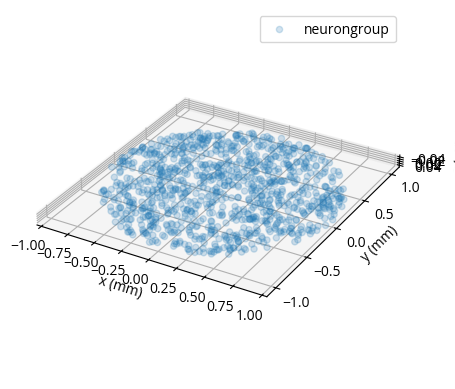

In [4]:
cleo.coords.assign_coords_rand_cylinder(neurons, [0, 0, 0], [0, 0, 0], 1)
cleo.viz.plot(neurons, xlim=[-1, 1], axis_scale_unit=b2.mm)

## Multi-electrode array (MEA)
Spacing appears to be 200 μm.

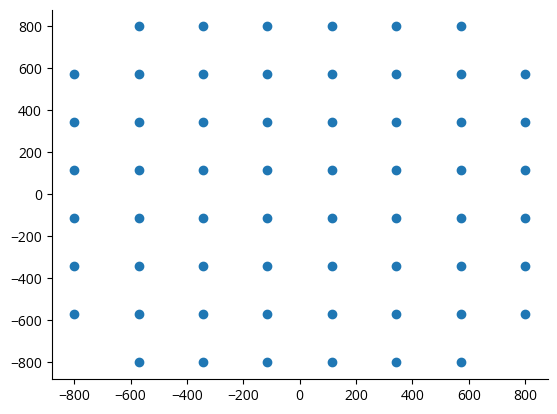

In [5]:
space = 200 * b2.um
n_side = 8
radius = space * n_side / 2
x, y = np.meshgrid(np.linspace(-radius, radius, n_side), np.linspace(-radius, radius, n_side))
y.shape
xy = np.column_stack([x.ravel(), y.ravel()]) * b2.meter
xy = np.delete(xy, [0, n_side - 1, -n_side, -1], 0) * b2.meter
plt.scatter(xy[:, 0] / b2.um, xy[:, 1] / b2.um)
# xy

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

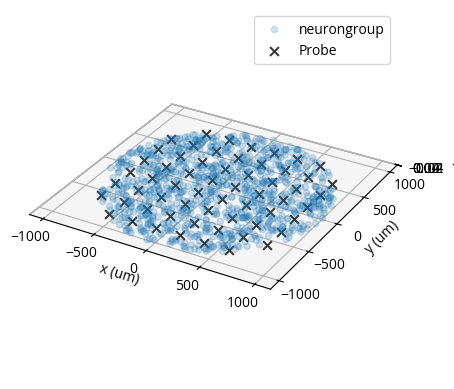

In [6]:
xyz = np.column_stack([xy, np.zeros(xy.shape[0])]) * b2.meter
spikes = cleo.ephys.SortedSpiking(r_perfect_detection=40 * b2.um, r_half_detection=80 * b2.um)
probe = cleo.ephys.Probe(coords=xyz, signals=[spikes])
sim.inject(probe, neurons)
cleo.viz.plot(neurons, devices=[probe])

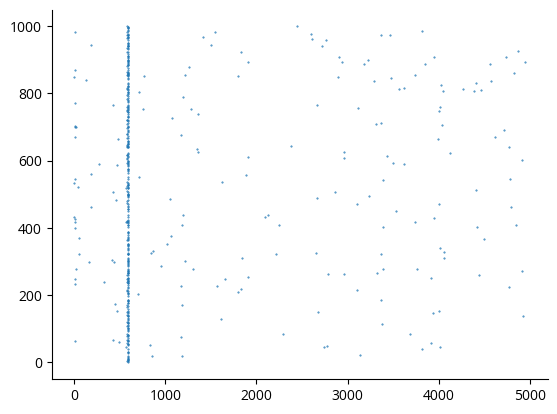

In [7]:
# sigma_ext = 0.05
# neurons.w_external_factor = rng.lognormal(0, sigma_ext, neurons.N) / np.exp(sigma_ext**2 / 2)
# plt.figure()
# plt.hist(neurons.w_external_factor)
# print(np.exp(sigma_ext**2 / 2))
# neurons.w_external_factor = 1
# w_external = 0.1 * b2.mV
# w0 = 0.78 * b2.mV
# w0 = 0 * b2.mV
# J_excit = w0
# J_inhib = -g * w0
sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
sim.run(5 * b2.second)
plt.figure()
plt.scatter(spikes.t_ms, spikes.i, s=0.2)
sim.reset()
# plt.xlim(0, 10000)

## Optogenetics

In [8]:
blue = cleo.light.Light(
    name="blue light",
    coords=[0, 0, -100] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=465 * b2.nmeter,
)
chr2r = cleo.opto.chr2_h134r_4s()
sim.inject(blue, neurons)
sigma_expr = 0.2
sim.inject(
    chr2r,
    neurons,
    Iopto_var_name="I_ChR2R",
    rho_rel=0.3 * rng.lognormal(0, sigma_expr, neurons.N) / np.exp(sigma_expr**2 / 2),
)

yellow = cleo.light.Light(
    name="yellow light",
    coords=[0, 0, -250] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=590 * b2.nmeter,
)
enphr3 = cleo.opto.enphr3_3s()
sim.inject(yellow, neurons)
sim.inject(
    enphr3,
    neurons,
    Iopto_var_name="I_eNpHR3",
    rho_rel=0.001 * rng.lognormal(0, sigma_expr, neurons.N) / np.exp(sigma_expr**2 / 2),
)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/light/light_dependence.py:88: UserWarning: λ = 590.0 nm is outside the range of the action spectrum data for ChR2(H134R). Assuming ε = 0.
  warnings.warn(
 [py.warnings]


CLSimulator(io_processor=RecordOnlyProcessor(sample_period_ms=1, sampling='fixed', processing='parallel'), devices={BansalThreeStatePump(name='eNpHR3.0', save_history=True, on_pre='', spectrum=[(390, 0.162), (405, 0.239), (430, 0.255), (445, 0.255), (470, 0.371), (495, 0.554), (520, 0.716), (542.5, 0.84), (560, 0.93), (590, 1), (630, 0.385)], required_vars=[('Iopto', amp), ('v', volt)], Gd=25. * hertz, Gr=50. * hertz, ka=msecond ** -1, p=0.7, q=0.1, phim=1.2e+24 * (second ** -1) / (meter ** 2), E=-0.4 * volt, g0=22.34 * nsiemens, a=2.e+08 * metre ** -3 * second ** -1 * amp ** -1 * mole, b=12, vartheta_max=5. * katal / (metre ** 3), kd=16. * mmolar, g_Cl=2.3 * nsiemens, Cl_out=124. * mmolar, Psi0=4.4286 * katal / (metre ** 3), E_Cl0=-70. * mvolt, vmin=-0.4 * volt, vmax=50. * mvolt, model='\n        dP0/dt = Gr*P6 - Ga*P0 : 1 (clock-driven)\n        dP4/dt = Ga*P0 - Gd*P4 : 1 (clock-driven)\n        P6 = 1 - P0 - P4 : 1\n\n        Theta = int(phi_pre > 0*phi_pre) : 1\n        Hp = Theta 

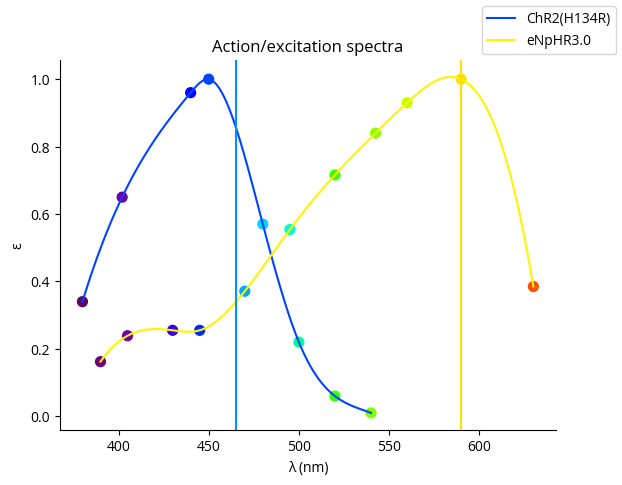

In [9]:
fig, ax = cleo.light.plot_spectra(chr2r, enphr3)
ax.axvline(465, color=blue.color)
ax.axvline(590, color=yellow.color)

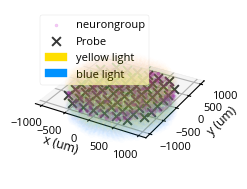

In [72]:
fig, ax = cleo.viz.plot(sim=sim, colors=['#c500cc'], figsize=(2.2, 2.2), scatterargs=dict(s=5))
ax.set(zticks=[])
# legend above plot
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1))
fig.savefig('img/fig/optoclamp-3d.svg', dpi=300, bbox_inches='tight', transparent=True)

## Eyeball test
Trying different levels of stimulation to ensure network activity looks roughly like the following:

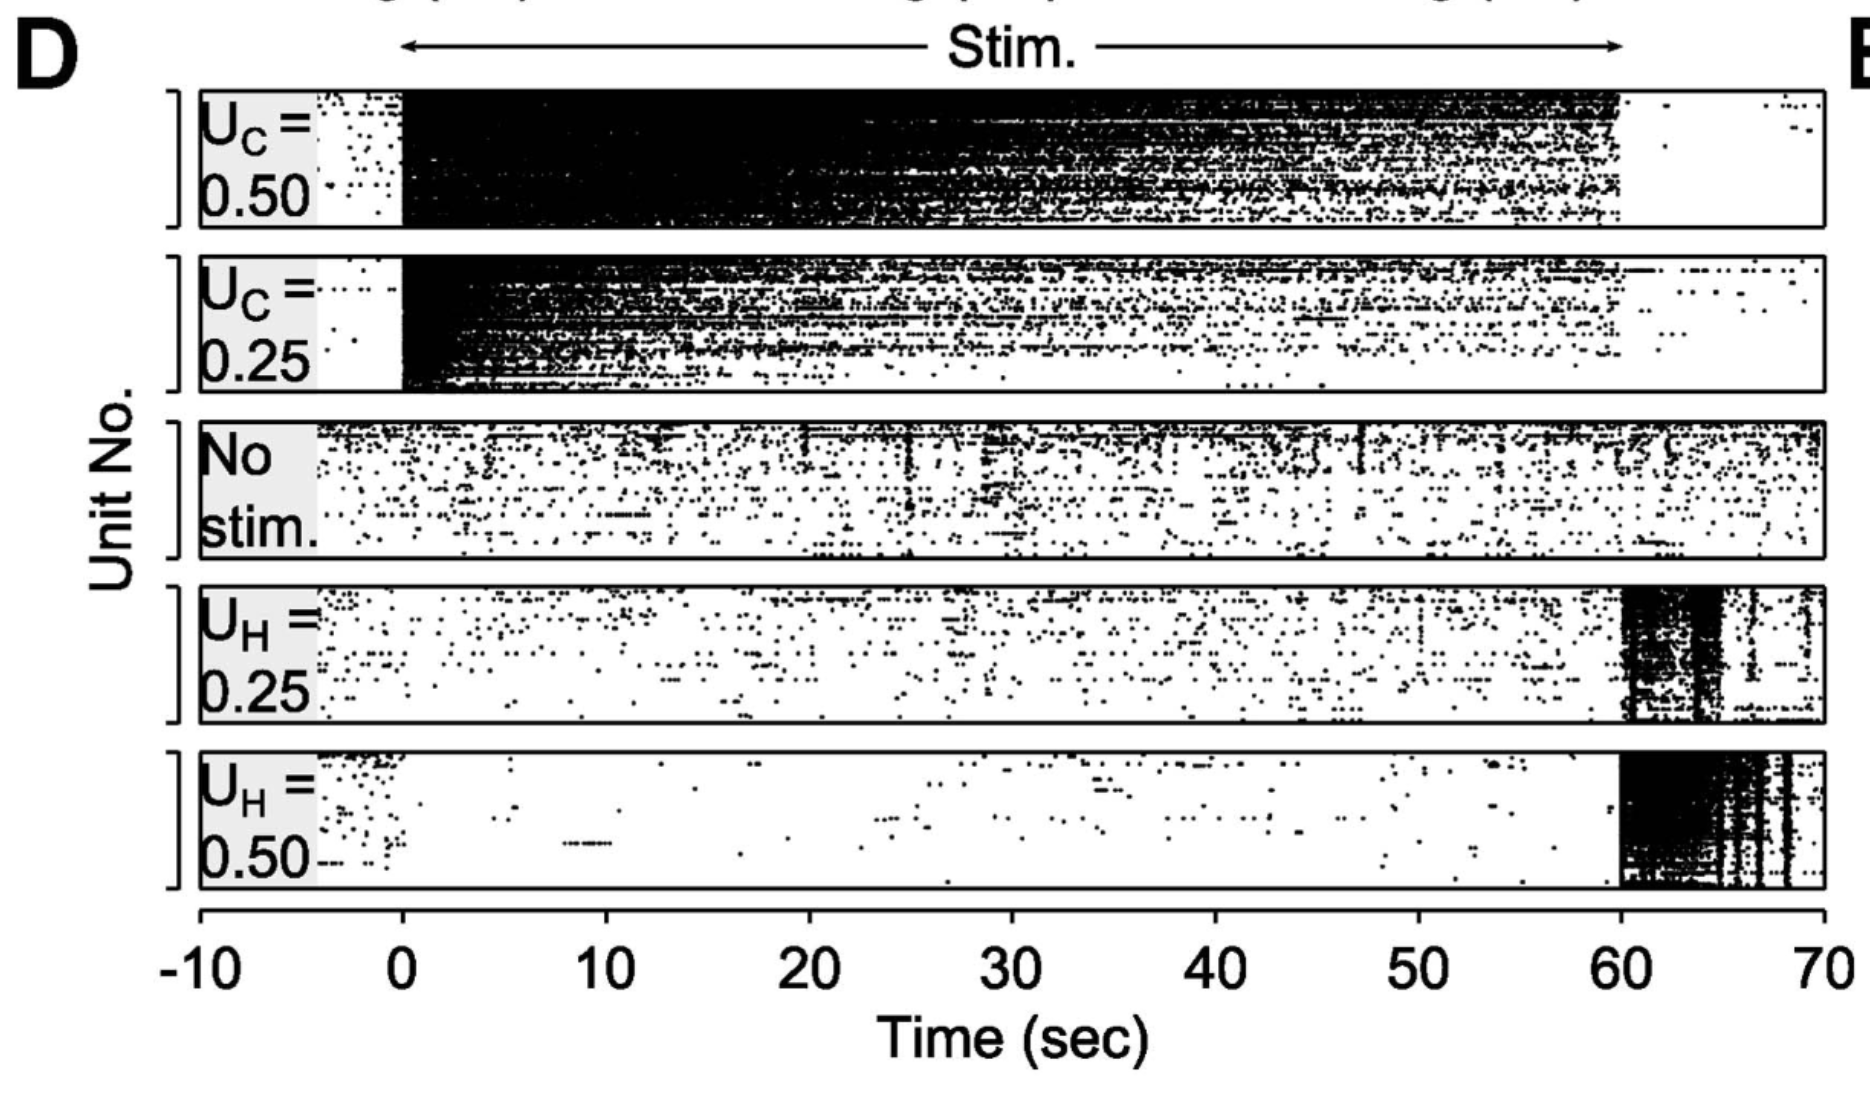

In [11]:
test_length_s = 9
intrvl_ms = test_length_s * 1000 / 9


class TestIOProc(cleo.ioproc.LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period_ms=1)
        self.UC_hist = []
        self.UH_hist = []

    def process(self, state_dict, t_sample_ms):
        UC, UH = 0, 0
        if 1 * intrvl_ms <= t_sample_ms < 2 * intrvl_ms:
            UC = 0.5
        elif 3 * intrvl_ms <= t_sample_ms < 4 * intrvl_ms:
            UC = 0.25
        elif 5 * intrvl_ms <= t_sample_ms < 6 * intrvl_ms:
            UH = 0.25
        elif 7 * intrvl_ms <= t_sample_ms < 8 * intrvl_ms:
            UH = 0.5

        self.UC_hist.append(UC)
        self.UH_hist.append(UH)
        return {"blue light": UC, "yellow light": UH}, t_sample_ms

    def preprocess_ctrl_signals(self, latest_ctrl_signals, t_ms):
        out = {}
        t = t_ms * b2.ms
        UC = latest_ctrl_signals.get("blue light", 0)
        pulse_freq_465nm = (10 * UC + 10) * b2.Hz
        pulse_width_465nm = 5 * UC * b2.ms
        power_465nm = 13.2 * UC
        on_465nm = t % (1 / pulse_freq_465nm) < pulse_width_465nm
        out["blue light"] = on_465nm * power_465nm

        UH = latest_ctrl_signals.get("yellow light", 0)
        out["yellow light"] = UH * 11.8
        return out


sim.reset()
test_proc = TestIOProc()
sim.set_io_processor(test_proc)
sim.run(test_length_s * b2.second, report="text")

INFO       No numerical integration method specified for group 'syn_ChR2_H134R__neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_eNpHR3_0_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 9. s
0.95 s (10%) simulated in 10s, estimated 1m 25s remaining.
1.7952 s (19%) simulated in 20s, estimated 1m 20s remaining.
2.7834 s (30%) simulated in 30s, estimated 1m 7s remaining.
3.7696 s (41%) simulated in 40s, estimated 56s remaining.
4.7212 s (52%) simulated in 50s, estimated 45s remaining.
5.6852 s (63%) simulated in 1m 0s, estimated 35s remaining.
6.6412 s (73%) simulated in 1m 10s, estimated 25s remaining.
7.503 s (83%) simulated in 1m 20s, estimated 16s remaining.
8.1992 s (91%) simulated in 1m 30s, estimated 9s remaining.
8.8308 s (98%) simulated in 1m 40s, estimated 2s remaining.
9. s (100%) simulated in 1m 42s


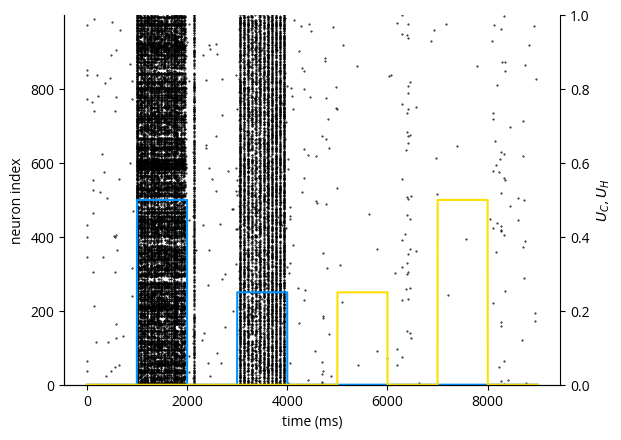

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.scatter(spikes.t_ms, spikes.i, s=0.2, color="k")
ax.set(ylim=[0, max(spikes.i)], ylabel="neuron index", xlabel="time (ms)")
ax.spines["right"].set_visible(True)
ax2.plot(test_proc.t_samp_ms, test_proc.UC_hist, color=blue.color, label="$U_C$")
ax2.plot(test_proc.t_samp_ms, test_proc.UH_hist, color=yellow.color, label="$U_H$")
ax2.set(ylim=[0, 1], ylabel="$U_C, U_H$");

## PI control

In [13]:
class Controller(cleo.ioproc.LatencyIOProcessor):
    def __init__(self, sample_period_ms=4):
        super().__init__(sample_period_ms=sample_period_ms)
        self.fre = cleo.ioproc.FiringRateEstimator(
            tau_ms=2500, sample_period_ms=sample_period_ms
        )
        self.Ts = 0.01 * b2.second  # control period (round-trip time)
        self.Ti = 1 * b2.second  # integral time constant
        self.K = 0.1  # proportional gain
        self.u = 0
        self.ef_prev = 0
        self.Δ = 0.25  # overlap between ChR2 and eNpHR3
        self.uu = []
        self.UCs = []
        self.UHs = []
        self.frs = []
        self.target = 1
        self.timepoints = [10, 20, 80, 90] * b2.second
        # self.timepoints = [1, 2, 3, 4] * b2.second * 5
        # self.timepoints = [2, 7, 22, 27] * b2.second

    def process(self, state_dict, t_sample_ms):
        t = t_sample_ms * b2.ms
        _, _, spike_counts = state_dict["Probe"]["SortedSpiking"]
        f, _ = self.fre.process(spike_counts, t_sample_ms, sample_time_ms=t_sample_ms)
        f = np.mean(f)
        self.frs.append(f)
        if t < self.timepoints[0]:
            UC = 1
            UH = 0
        elif t < self.timepoints[1]:
            UC = 0
            UH = 0
        elif t < self.timepoints[2]:
            ef = self.target - f  # error in firing rate
            self.u = self.u + self.K * (ef - self.ef_prev + self.Ts / self.Ti * ef)
            self.uu.append(self.u)
            UC = self.u + self.Δ
            UC = np.clip(UC, 0, 1)
            UH = -self.u + self.Δ
            UH = np.clip(UH, 0, 1)
            self.ef_prev = ef
        elif t >= self.timepoints[2]:
            UC = 0
            UH = 0

        self.UCs.append(UC)
        self.UHs.append(UH)

        return {"blue light": UC, "yellow light": UH}, t_sample_ms + self.Ts / b2.ms

    def preprocess_ctrl_signals(self, latest_ctrl_signals, t_ms):
        out = {}
        t = t_ms * b2.ms
        UC = latest_ctrl_signals.get("blue light", 0)
        pulse_freq_465nm = (10 * UC + 10) * b2.Hz
        pulse_width_465nm = 5 * UC * b2.ms
        power_465nm = 13.2 * UC
        on_465nm = t % (1 / pulse_freq_465nm) < pulse_width_465nm
        out["blue light"] = on_465nm * power_465nm

        UH = latest_ctrl_signals.get("yellow light", 0)
        out["yellow light"] = UH * 11.8
        return out

ctrlr = Controller()

In [14]:
def plot_results(t_ms, frs, UCs, UHs, target):
    t = np.array(t_ms) / 1000
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 6))
    axs[0].plot(t, frs)
    axs[0].set(ylabel="firing rate (Hz)")
    axs[0].hlines(target, ctrlr.timepoints[1], ctrlr.timepoints[2])
    axs[1].plot(t, UCs, label="$U_C$", color=blue.color)
    axs[1].plot(t, UHs, label="$U_H$", color=yellow.color)
    axs[1].set(ylabel="$U_C,U_H$", xlabel="time (s)")
    axs[1].legend()
    display(fig)
    plt.close(fig)

In [15]:
results = {}

target = 0
Starting simulation at t=0. s for a duration of 90. s


4.3248 s (4%) simulated in 1m 0s, estimated 19m 49s remaining.
9.048 s (10%) simulated in 2m 0s, estimated 17m 54s remaining.
12.8734 s (14%) simulated in 3m 0s, estimated 17m 58s remaining.
17.4852 s (19%) simulated in 4m 0s, estimated 16m 35s remaining.
21.947 s (24%) simulated in 5m 0s, estimated 15m 30s remaining.
26.695 s (29%) simulated in 6m 0s, estimated 14m 14s remaining.
31.5058 s (35%) simulated in 7m 0s, estimated 13m 0s remaining.
36.1702 s (40%) simulated in 8m 0s, estimated 11m 54s remaining.
40.8526 s (45%) simulated in 9m 0s, estimated 10m 50s remaining.
45.1696 s (50%) simulated in 10m 0s, estimated 9m 56s remaining.
49.5872 s (55%) simulated in 11m 0s, estimated 8m 58s remaining.
53.8322 s (59%) simulated in 12m 0s, estimated 8m 4s remaining.
58.6226 s (65%) simulated in 13m 0s, estimated 6m 57s remaining.
63.2598 s (70%) simulated in 14m 0s, estimated 5m 55s remaining.
67.5408 s (75%) simulated in 15m 0s, estimated 4m 59s remaining.
71.6312 s (79%) simulated in 16m 

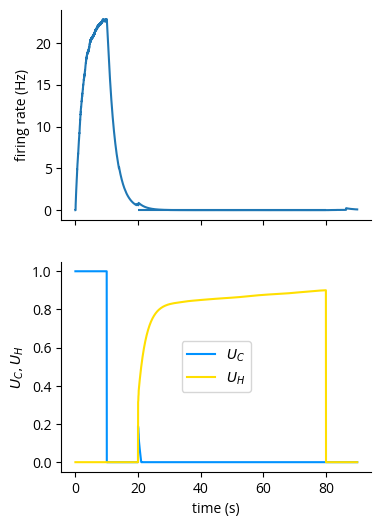

target = 1
Starting simulation at t=0. s for a duration of 90. s
5.198 s (5%) simulated in 1m 0s, estimated 16m 19s remaining.
10.5918 s (11%) simulated in 2m 0s, estimated 15m 0s remaining.
16.0224 s (17%) simulated in 3m 0s, estimated 13m 51s remaining.
21.1268 s (23%) simulated in 4m 0s, estimated 13m 2s remaining.
26.4166 s (29%) simulated in 5m 0s, estimated 12m 2s remaining.
32.2326 s (35%) simulated in 6m 0s, estimated 10m 45s remaining.
37.783 s (41%) simulated in 7m 0s, estimated 9m 40s remaining.
43.499 s (48%) simulated in 8m 0s, estimated 8m 33s remaining.
49.1974 s (54%) simulated in 9m 0s, estimated 7m 28s remaining.
54.176 s (60%) simulated in 10m 0s, estimated 6m 37s remaining.
59.3976 s (65%) simulated in 11m 0s, estimated 5m 40s remaining.
65.1494 s (72%) simulated in 12m 0s, estimated 4m 35s remaining.
70.8056 s (78%) simulated in 13m 0s, estimated 3m 31s remaining.
75.7364 s (84%) simulated in 14m 0s, estimated 2m 38s remaining.
80.918 s (89%) simulated in 15m 0s, e

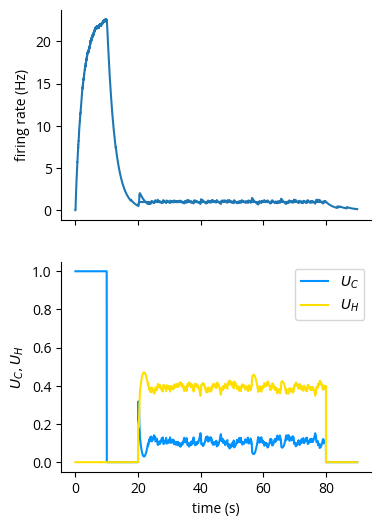

target = 2
Starting simulation at t=0. s for a duration of 90. s
5.3376 s (5%) simulated in 1m 0s, estimated 15m 52s remaining.
10.7968 s (11%) simulated in 2m 0s, estimated 14m 40s remaining.
16.3904 s (18%) simulated in 3m 0s, estimated 13m 28s remaining.
22.1738 s (24%) simulated in 4m 0s, estimated 12m 14s remaining.
27.803 s (30%) simulated in 5m 0s, estimated 11m 11s remaining.
32.9368 s (36%) simulated in 6m 0s, estimated 10m 24s remaining.
37.946 s (42%) simulated in 7m 0s, estimated 9m 36s remaining.
43.1956 s (47%) simulated in 8m 0s, estimated 8m 40s remaining.
48.3988 s (53%) simulated in 9m 0s, estimated 7m 44s remaining.
53.3826 s (59%) simulated in 10m 0s, estimated 6m 52s remaining.
58.8052 s (65%) simulated in 11m 0s, estimated 5m 50s remaining.
64.4326 s (71%) simulated in 12m 0s, estimated 4m 46s remaining.
69.614 s (77%) simulated in 13m 0s, estimated 3m 48s remaining.
75.3188 s (83%) simulated in 14m 0s, estimated 2m 44s remaining.
80.6286 s (89%) simulated in 15m 

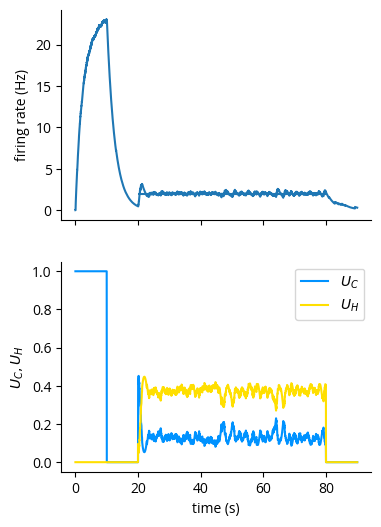

target = 3
Starting simulation at t=0. s for a duration of 90. s
5.7382 s (6%) simulated in 1m 0s, estimated 14m 41s remaining.
10.9472 s (12%) simulated in 2m 0s, estimated 14m 27s remaining.
16.5206 s (18%) simulated in 3m 0s, estimated 13m 21s remaining.
21.6028 s (24%) simulated in 4m 0s, estimated 12m 40s remaining.
26.5102 s (29%) simulated in 5m 0s, estimated 11m 59s remaining.
32.3136 s (35%) simulated in 6m 0s, estimated 10m 43s remaining.
37.4074 s (41%) simulated in 7m 0s, estimated 9m 51s remaining.
42.7774 s (47%) simulated in 8m 0s, estimated 8m 50s remaining.
47.4104 s (52%) simulated in 9m 0s, estimated 8m 5s remaining.
52.879 s (58%) simulated in 10m 0s, estimated 7m 1s remaining.
58.5566 s (65%) simulated in 11m 0s, estimated 5m 54s remaining.
63.3888 s (70%) simulated in 12m 0s, estimated 5m 2s remaining.
68.351 s (75%) simulated in 13m 0s, estimated 4m 7s remaining.
73.622 s (81%) simulated in 14m 0s, estimated 3m 7s remaining.
78.7916 s (87%) simulated in 15m 0s, e

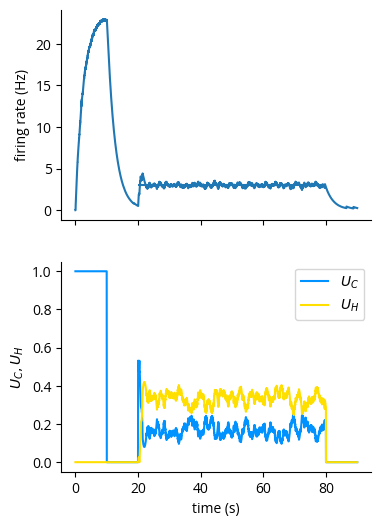

target = 4
Starting simulation at t=0. s for a duration of 90. s
5.3652 s (5%) simulated in 1m 0s, estimated 15m 47s remaining.
10.5302 s (11%) simulated in 2m 0s, estimated 15m 6s remaining.
15.7146 s (17%) simulated in 3m 0s, estimated 14m 11s remaining.
21.2152 s (23%) simulated in 4m 0s, estimated 12m 58s remaining.
26.8102 s (29%) simulated in 5m 0s, estimated 11m 47s remaining.
31.5548 s (35%) simulated in 6m 0s, estimated 11m 7s remaining.
35.9668 s (39%) simulated in 7m 0s, estimated 10m 31s remaining.
41.1246 s (45%) simulated in 8m 0s, estimated 9m 30s remaining.
45.8936 s (50%) simulated in 9m 0s, estimated 8m 39s remaining.
50.3518 s (55%) simulated in 10m 0s, estimated 7m 52s remaining.
54.7624 s (60%) simulated in 11m 0s, estimated 7m 5s remaining.
59.8806 s (66%) simulated in 12m 0s, estimated 6m 2s remaining.
64.8026 s (72%) simulated in 13m 0s, estimated 5m 3s remaining.
69.893 s (77%) simulated in 14m 0s, estimated 4m 2s remaining.
74.2894 s (82%) simulated in 15m 0s,

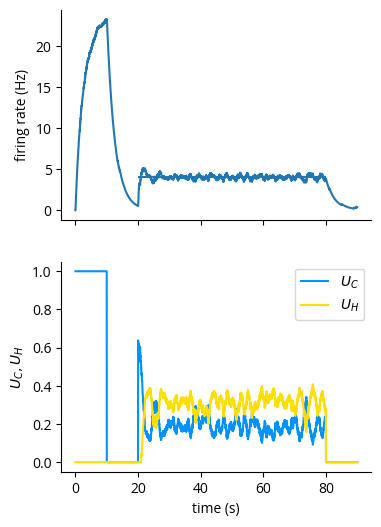

target = 5
Starting simulation at t=0. s for a duration of 90. s
4.4498 s (4%) simulated in 1m 0s, estimated 19m 14s remaining.
9.773 s (10%) simulated in 2m 0s, estimated 16m 25s remaining.
15.2974 s (16%) simulated in 3m 0s, estimated 14m 39s remaining.
20.5274 s (22%) simulated in 4m 0s, estimated 13m 32s remaining.
25.406 s (28%) simulated in 5m 0s, estimated 12m 43s remaining.
31.1876 s (34%) simulated in 6m 0s, estimated 11m 19s remaining.
36.4108 s (40%) simulated in 7m 0s, estimated 10m 18s remaining.
41.3462 s (45%) simulated in 8m 0s, estimated 9m 25s remaining.
46.5506 s (51%) simulated in 9m 0s, estimated 8m 24s remaining.
52.3036 s (58%) simulated in 10m 0s, estimated 7m 12s remaining.
57.8828 s (64%) simulated in 11m 0s, estimated 6m 6s remaining.
62.94 s (69%) simulated in 12m 0s, estimated 5m 10s remaining.
68.5966 s (76%) simulated in 13m 0s, estimated 4m 3s remaining.
73.0966 s (81%) simulated in 14m 0s, estimated 3m 14s remaining.
78.0586 s (86%) simulated in 15m 0s,

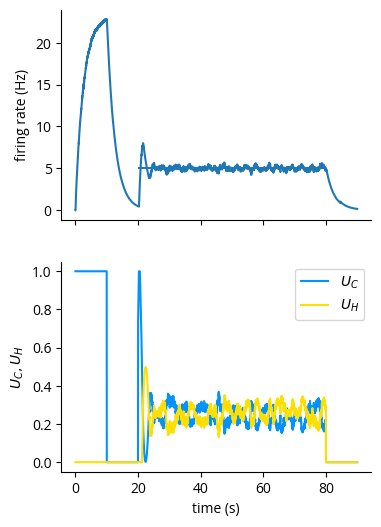

target = 6
Starting simulation at t=0. s for a duration of 90. s
5.1144 s (5%) simulated in 1m 0s, estimated 16m 36s remaining.
9.712 s (10%) simulated in 2m 0s, estimated 16m 32s remaining.
14.455 s (16%) simulated in 3m 0s, estimated 15m 41s remaining.
19.9498 s (22%) simulated in 4m 0s, estimated 14m 3s remaining.
24.1998 s (26%) simulated in 16h 5m 2s, estimated 1d 19h 43m 59s remaining.
26.1162 s (29%) simulated in 16h 6m 2s, estimated 1d 15h 23m 4s remaining.
31.3214 s (34%) simulated in 16h 7m 2s, estimated 1d 6h 11m 41s remaining.
37.4836 s (41%) simulated in 16h 8m 2s, estimated 22h 36m 16s remaining.
43.9408 s (48%) simulated in 16h 9m 2s, estimated 16h 55m 45s remaining.
50.0178 s (55%) simulated in 16h 10m 2s, estimated 12h 55m 25s remaining.
55.9642 s (62%) simulated in 16h 11m 2s, estimated 9h 50m 33s remaining.
62.6164 s (69%) simulated in 16h 12m 2s, estimated 7h 5m 6s remaining.
69.0772 s (76%) simulated in 16h 13m 2s, estimated 4h 54m 43s remaining.
75.4404 s (83%) si

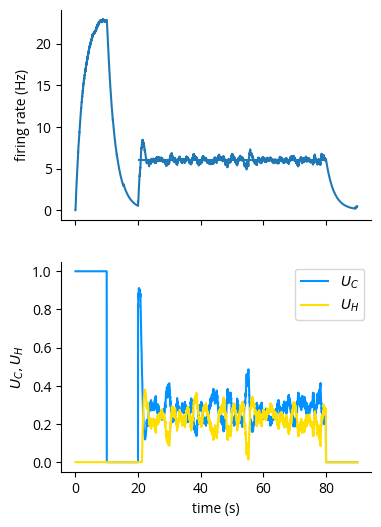

target = 7
Starting simulation at t=0. s for a duration of 90. s
5.9782 s (6%) simulated in 1m 0s, estimated 14m 3s remaining.
11.7324 s (13%) simulated in 2m 0s, estimated 13m 21s remaining.
18.1968 s (20%) simulated in 3m 0s, estimated 11m 50s remaining.
24.542 s (27%) simulated in 4m 0s, estimated 10m 40s remaining.
30.8314 s (34%) simulated in 5m 0s, estimated 9m 36s remaining.
36.2338 s (40%) simulated in 6m 0s, estimated 8m 54s remaining.
41.5274 s (46%) simulated in 7m 0s, estimated 8m 10s remaining.
47.071 s (52%) simulated in 8m 0s, estimated 7m 18s remaining.
52.6092 s (58%) simulated in 9m 0s, estimated 6m 24s remaining.
58.5766 s (65%) simulated in 10m 0s, estimated 5m 22s remaining.
64.5588 s (71%) simulated in 11m 0s, estimated 4m 20s remaining.
70.0358 s (77%) simulated in 12m 0s, estimated 3m 25s remaining.
75.246 s (83%) simulated in 13m 0s, estimated 2m 33s remaining.
80.2564 s (89%) simulated in 14m 0s, estimated 1m 42s remaining.
85.3954 s (94%) simulated in 15m 0s,

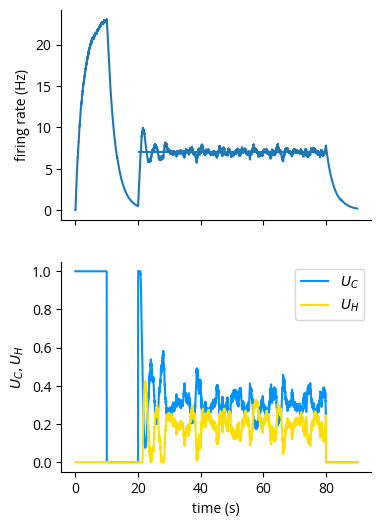

target = 8
Starting simulation at t=0. s for a duration of 90. s
5.0328 s (5%) simulated in 1m 0s, estimated 16m 53s remaining.
10.5744 s (11%) simulated in 2m 0s, estimated 15m 1s remaining.
16.7554 s (18%) simulated in 3m 0s, estimated 13m 7s remaining.
22.6548 s (25%) simulated in 4m 0s, estimated 11m 53s remaining.
28.6752 s (31%) simulated in 5m 0s, estimated 10m 42s remaining.
34.5978 s (38%) simulated in 6m 0s, estimated 9m 36s remaining.
40.5144 s (45%) simulated in 7m 0s, estimated 8m 33s remaining.
46.0656 s (51%) simulated in 8m 0s, estimated 7m 38s remaining.
50.7954 s (56%) simulated in 9m 0s, estimated 6m 57s remaining.
56.2116 s (62%) simulated in 10m 0s, estimated 6m 1s remaining.
61.4026 s (68%) simulated in 11m 0s, estimated 5m 7s remaining.
66.1746 s (73%) simulated in 12m 0s, estimated 4m 19s remaining.
71.09 s (78%) simulated in 13m 0s, estimated 3m 27s remaining.
76.0992 s (84%) simulated in 14m 0s, estimated 2m 33s remaining.
80.9006 s (89%) simulated in 15m 0s, 

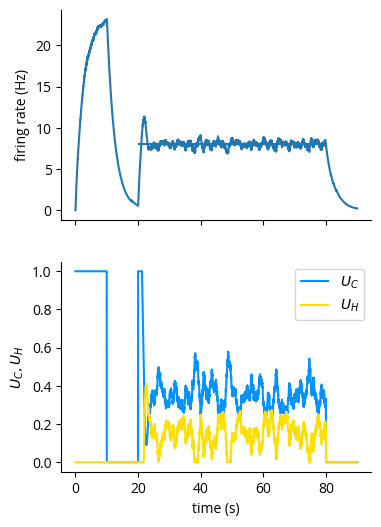

target = 9
Starting simulation at t=0. s for a duration of 90. s
5.8238 s (6%) simulated in 1m 0s, estimated 14m 27s remaining.
11.3472 s (12%) simulated in 2m 0s, estimated 13m 52s remaining.
16.8864 s (18%) simulated in 3m 0s, estimated 12m 59s remaining.
21.5152 s (23%) simulated in 4m 0s, estimated 12m 44s remaining.
26.759 s (29%) simulated in 5m 0s, estimated 11m 49s remaining.
32.155 s (35%) simulated in 6m 0s, estimated 10m 48s remaining.
37.6578 s (41%) simulated in 7m 0s, estimated 9m 44s remaining.
43.6072 s (48%) simulated in 8m 0s, estimated 8m 31s remaining.
49.44 s (54%) simulated in 9m 0s, estimated 7m 23s remaining.
55.1548 s (61%) simulated in 10m 0s, estimated 6m 19s remaining.
60.9512 s (67%) simulated in 11m 0s, estimated 5m 15s remaining.
64.6168 s (71%) simulated in 12m 0s, estimated 4m 43s remaining.
70.8192 s (78%) simulated in 13m 0s, estimated 3m 31s remaining.
76.9384 s (85%) simulated in 14m 0s, estimated 2m 23s remaining.
82.9704 s (92%) simulated in 15m 0

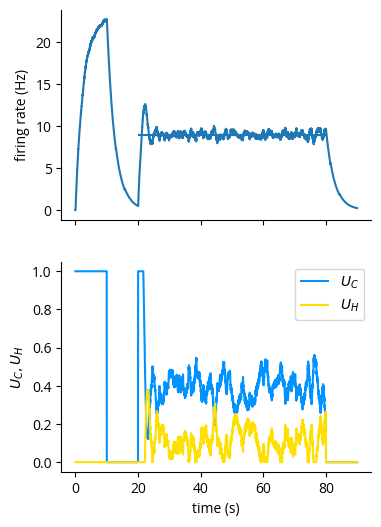

target = 10
Starting simulation at t=0. s for a duration of 90. s
5.3682 s (5%) simulated in 1m 0s, estimated 15m 46s remaining.
10.7438 s (11%) simulated in 2m 0s, estimated 14m 45s remaining.
16.7818 s (18%) simulated in 3m 0s, estimated 13m 5s remaining.
22.6076 s (25%) simulated in 4m 0s, estimated 11m 55s remaining.
27.9536 s (31%) simulated in 5m 0s, estimated 11m 6s remaining.
33.5514 s (37%) simulated in 6m 0s, estimated 10m 6s remaining.
38.9606 s (43%) simulated in 7m 0s, estimated 9m 10s remaining.
44.5084 s (49%) simulated in 8m 0s, estimated 8m 11s remaining.
49.8102 s (55%) simulated in 9m 0s, estimated 7m 16s remaining.
55.095 s (61%) simulated in 10m 0s, estimated 6m 20s remaining.
60.182 s (66%) simulated in 11m 0s, estimated 5m 27s remaining.
65.2698 s (72%) simulated in 12m 0s, estimated 4m 33s remaining.
70.4748 s (78%) simulated in 13m 0s, estimated 3m 36s remaining.
75.6062 s (84%) simulated in 14m 0s, estimated 2m 40s remaining.
80.6512 s (89%) simulated in 15m 0

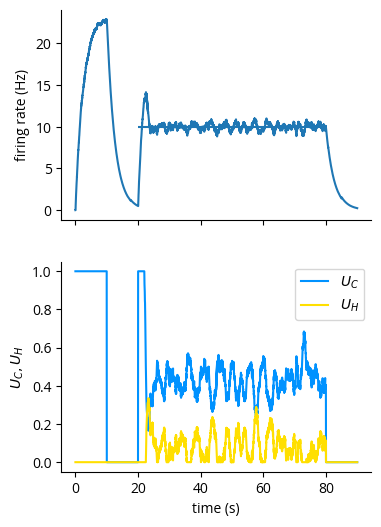

In [16]:
from IPython.display import display
import pickle
import os

targets = range(11)
# targets = [2, 3, 4, 5]
ctrlr = Controller()
for target in targets:
    filename = f"results/results_{target}.pkl"
    if os.path.exists(filename):
        print(f"results for target {target} already saved. skipping.")
        continue

    ctrlr = Controller()
    sim.reset()
    sim.set_io_processor(ctrlr)
    ctrlr.target = target
    print(f"target = {target}")
    sim.run(ctrlr.timepoints[-1], report_period=60 * b2.second, report="text")

    results[target] = (
        ctrlr.t_samp_ms,
        ctrlr.frs,
        ctrlr.UCs,
        ctrlr.UHs,
    )
    with open(filename, "wb") as file:
        pickle.dump(results[target], file)

    plot_results(*results[target], target)

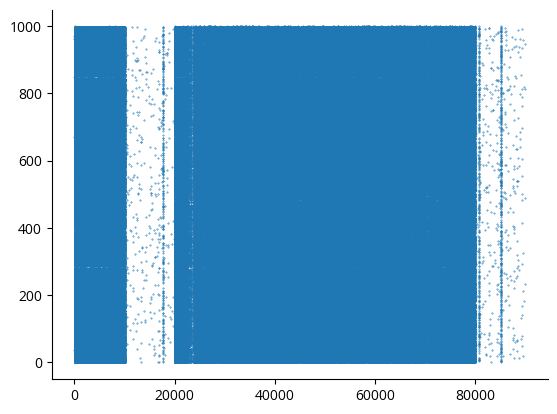

In [17]:
plt.scatter(spikes.t_ms, spikes.i, marker='.', s=.5)

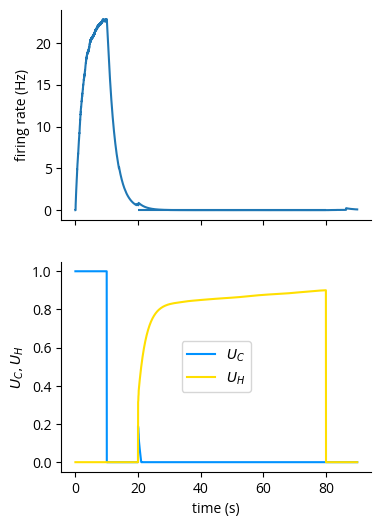

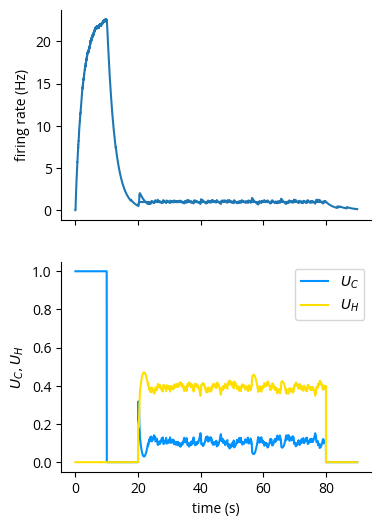

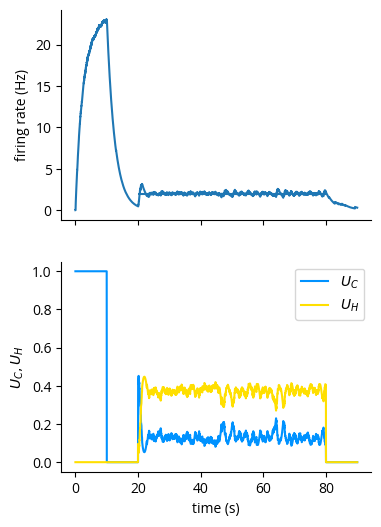

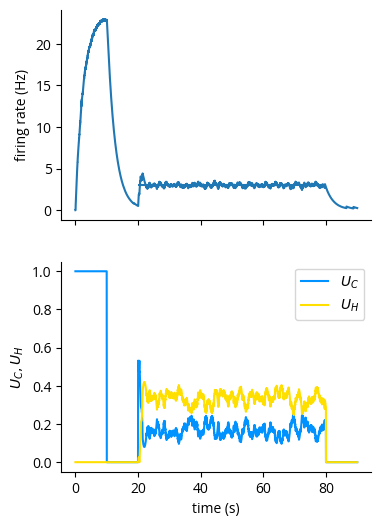

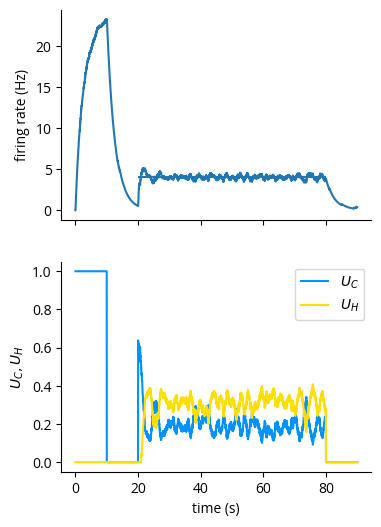

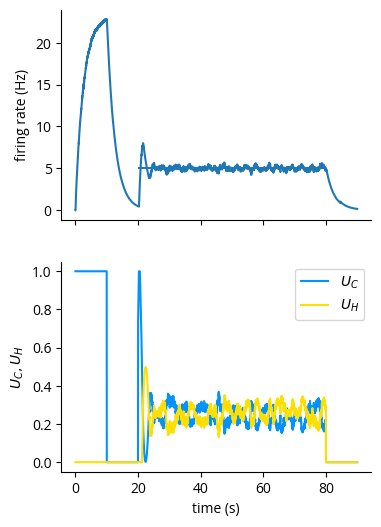

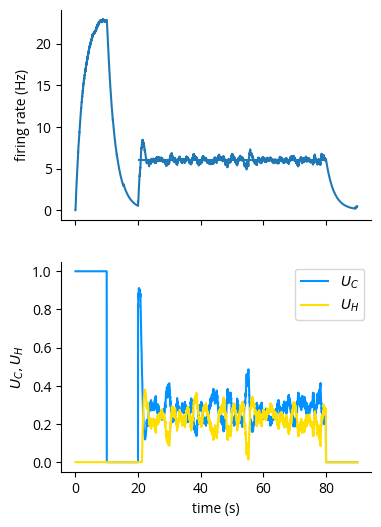

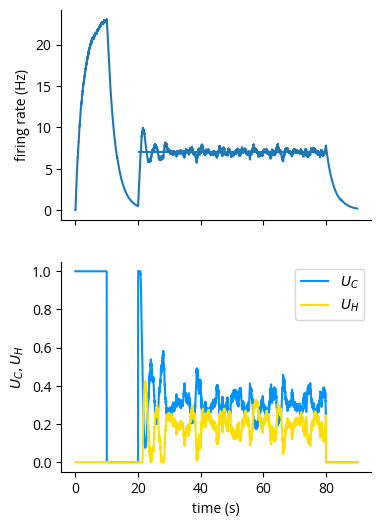

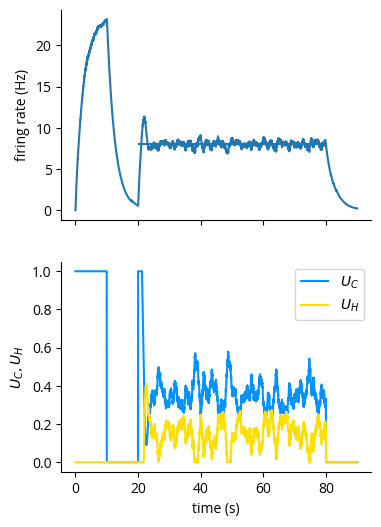

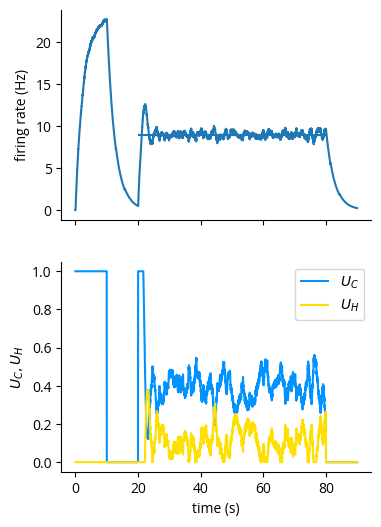

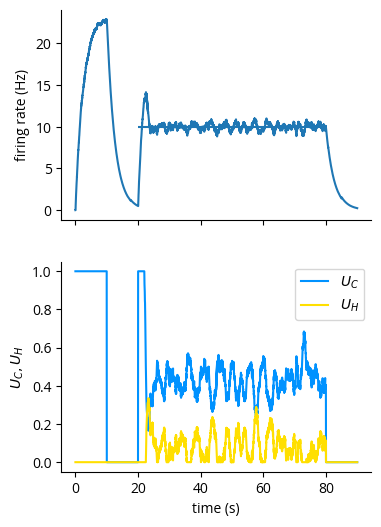

In [18]:
for target in targets:
    with open(f"results/results_{target}.pkl", "rb") as file:
        t_ms, frs, UCs, UHs = pickle.load(file)
    plot_results(t_ms, frs, UCs, UHs, target)

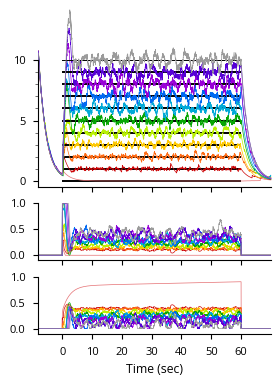

In [80]:
from matplotlib import ticker

plt.style.use("seaborn-v0_8-paper")
figwidth = 3
fig, axs = plt.subplots(
    3,
    1,
    sharex=True,
    figsize=(figwidth, figwidth * 3.2 / 2.7),
    height_ratios=[2.22, 1, 1],
    # layout="constrained",
)
rainbow_cycler = plt.cycler(
    color=[
        "#e56f72",
        "#cd0608",
        "#fd6b16",
        "#fdc803",
        "#b8f003",
        "#08a605",
        "#02a9d7",
        "#0169f1",
        "#9900d7",
        "#5601d5",
        "#9b9b9b",
    ]
)
for ax in axs:
    ax.set_prop_cycle(rainbow_cycler)

offset_s = 20
t_start_s = -8
lw = 0.5
for target in targets:
    with open(f"results/results_{target}.pkl", "rb") as file:
        t_ms, frs, UCs, UHs = pickle.load(file)
    t = np.array(t_ms) / 1000 - offset_s
    axs[0].hlines(
        target,
        ctrlr.timepoints[1] / b2.second - offset_s,
        ctrlr.timepoints[2] / b2.second - offset_s,
        color="k",
    )
    axs[0].plot(t[t >= t_start_s], np.array(frs)[t >= t_start_s], clip_on=False, lw=lw)
    axs[0].set(
        # ylabel="Firing rate (Hz/unit)",
        ylim=[-0.5, 10],
        # yticks=range(0, 11, 1),
        # yticklabels=range(0, 11, 5),
    )
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
    axs[0].yaxis.set_minor_locator(ticker.MultipleLocator(1))
    axs[1].plot(t, UCs, lw=lw)
    axs[1].set(
        # ylabel="$U_C$",
        ylim=[-0.1, 1],
        yticks=[0, 0.5, 1],
    )
    axs[2].plot(t, UHs, lw=lw)
    axs[2].set(
        # ylabel="$U_H$",
        xlabel="Time (sec)",
        ylim=[-0.1, 1],
        xlim=[t_start_s, max(t)],
        yticks=[0, 0.5, 1],
        xticks=range(0, 70, 10),
    )
    fig.savefig("img/fig/optoclamp-frs.png", dpi=300, bbox_inches="tight", transparent=True)

In [20]:

# # Retrieve objects from the file
# with open('data.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)
#     loaded_numbers = pickle.load(file)

# print(loaded_data)  # Output: {'name': 'John', 'age': 30}
# print(loaded_numbers)  # Output: [1, 2, 3, 4, 5]